In [1]:
import draw
from params import *
import torch
import numpy as np

In [2]:
hand = draw.Hand("/home/bobby/final_proj/saved_models/All-Writers-No-Noise-Large")

/home/bobby/final_proj/saved_models/All-Writers-No-Noise-Large : Model loaded Successfully


In [3]:
enc_embed = hand.model.src_embed
encoder = hand.model.encoder
dec_embed = hand.model.tgt_embed
decoder = hand.model.decoder

In [15]:
batch = {}
batch['c'] = torch.tensor([alpha_to_num[c] for c in "hello"]).unsqueeze(0).to(DEVICE)
batch['c_len'] = torch.tensor([len(batch['c'])]).unsqueeze(0).to(DEVICE)

batch_seq_char = batch['c']
batch_seq_char_len = batch['c_len']

print(batch_seq_char.shape)
print(batch_seq_char_len.shape)

self = hand.model.to(DEVICE)

encode_embed = self.src_embed(batch_seq_char).to(DEVICE)
src_key_padding_mask = self.create_pad_mask(encode_embed, batch_seq_char_len).to(DEVICE)
encoding = encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask).to(DEVICE)

output_len = 100
output = torch.zeros(size=[1, output_len, 3]).to(DEVICE)
output[0, 0, -1] = 1

for t in range(1, output_len):
    tgt_emb = dec_embed(output[:, :t]).to(DEVICE)
    tgt_mask = hand.model.create_mask(tgt_emb).to(DEVICE)
    decoder_output = decoder(tgt=tgt_emb,
                             memory=encoding,
                             tgt_mask=tgt_mask).to(DEVICE)
    decoder_output =  self.generator(decoder_output[:, [-1], :])
    # print(decoder_output.shape)
    decoder_output[:, :, -1] = torch.sigmoid(decoder_output[:, :, -1])
    # print(decoder_output.shape)
    output[:, t, :] = decoder_output

torch.Size([1, 5])
torch.Size([1, 1])


In [4]:
    def predict(self, batch_seq_char, batch_seq_char_len, max_output_len=500):
        """_summary_

        Args:
            batch_seq_char (N, L): sequence of character using the ALPHABET indexing
            batch_seq_char_len (N): lenght of each sequence in the batch
        """

        encode_embed = self.src_embed(batch_seq_char).to(DEVICE)
        src_key_padding_mask = self.create_pad_mask(encode_embed, batch_seq_char_len).to(DEVICE)
        encoding = self.encoder(src=encode_embed, src_key_padding_mask=src_key_padding_mask).to(DEVICE)

        output = torch.zeros(size=[1, max_output_len, 3]).to(DEVICE)
        output[0, 0, -1] = 1 # the starting point


        for t in range(1, max_output_len):
            tgt_emb = self.tgt_embed(output[:, :t]).to(DEVICE)
            tgt_mask = self.create_mask(tgt_emb).to(DEVICE)
            decoder_output = self.decoder(tgt=tgt_emb,
                                        memory=encoding,
                                        tgt_mask=tgt_mask).to(DEVICE)
            decoder_output =  self.generator(decoder_output[:, [-1], :])
            decoder_output[:, :, -1] = torch.sigmoid(decoder_output[:, :, -1])
            output[:, t, :] = decoder_output

        return output





In [5]:
batch = {}
batch['c'] = torch.tensor([alpha_to_num[c] for c in  r"""" I'll try to"""]).unsqueeze(0).to(DEVICE)
batch['c_len'] = torch.tensor([len(batch['c'])]).unsqueeze(0).to(DEVICE)

batch_seq_char = batch['c']
batch_seq_char_len = batch['c_len']

output = predict(hand.model.to(DEVICE), batch_seq_char, batch_seq_char_len, 612)
output[:, :, -1] = 0

In [6]:
output

tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.5407, -0.2865,  0.0000],
         [-0.6736, -0.9253,  0.0000],
         ...,
         [29.6050, -3.7728,  0.0000],
         [29.2165, -6.0678,  0.0000],
         [30.5831, -6.6985,  0.0000]]], device='cuda:0', grad_fn=<CopySlices>)

In [20]:
filename = "hello.svg"
hand._draw(strokes=output.cpu().detach().numpy(), lines=["hello"], filename=filename)

In [22]:
data_cols = ['x', 'x_len', 'c', 'c_len', 'w_id']
data_dir = "data/processed"
data = []

for col in data_cols:
    data.append(
        torch.from_numpy(
            np.load(os.path.join(data_dir, '{}.npy'.format(col)))
        ).to(DEVICE)
    )
data[2] = data[2].type(torch.int) # int8 is not compatible with Pytorch
print(data[0].shape)

torch.Size([11615, 1200, 3])


In [72]:
output = output.cpu().detach()

In [73]:
x_len = output.shape[1]
x = output[0]
abs_x = torch.cumsum(x, dim=0)

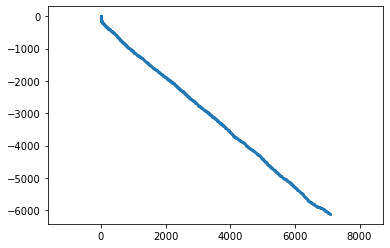

In [74]:
import matplotlib.pyplot as plt

# for t in range(x_len):
coord_x = abs_x[:600, 0]
coord_y = abs_x[:600, 1]
plt.scatter(coord_x.cpu(), coord_y.cpu(), 3)
plt.savefig("{}-file.jpg".format(t))
plt.axis('equal')
plt.show()

In [43]:
batch_seq_char_len.shape

torch.Size([1, 1])